Before oversampling:
 category
 1    57800
 0    44170
-1    28408
Name: count, dtype: int64
After oversampling:
 category
 1    57800
-1    57800
 0    57800
Name: count, dtype: int64

📌 Naive Bayes Results:
Accuracy: 0.7431814695505445
              precision    recall  f1-score   support

          -1       0.56      0.79      0.66      7102
           0       0.79      0.75      0.77     11043
           1       0.85      0.72      0.78     14450

    accuracy                           0.74     32595
   macro avg       0.73      0.75      0.73     32595
weighted avg       0.77      0.74      0.75     32595



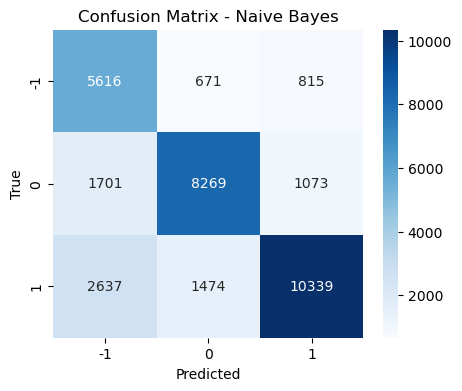


📌 Logistic Regression Results:
Accuracy: 0.8545175640435649
              precision    recall  f1-score   support

          -1       0.80      0.81      0.80      7102
           0       0.81      0.96      0.88     11043
           1       0.94      0.80      0.86     14450

    accuracy                           0.85     32595
   macro avg       0.85      0.86      0.85     32595
weighted avg       0.86      0.85      0.85     32595



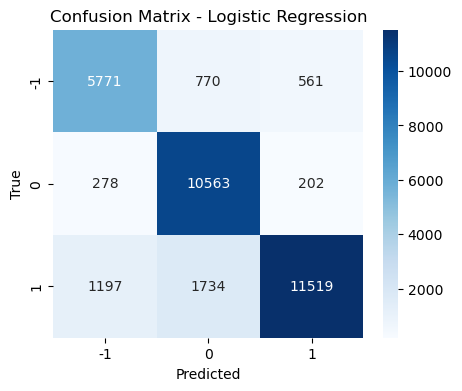


📌 SVM Results:
Accuracy: 0.8590274581991103
              precision    recall  f1-score   support

          -1       0.80      0.82      0.81      7102
           0       0.81      0.96      0.88     11043
           1       0.94      0.80      0.87     14450

    accuracy                           0.86     32595
   macro avg       0.85      0.86      0.85     32595
weighted avg       0.87      0.86      0.86     32595



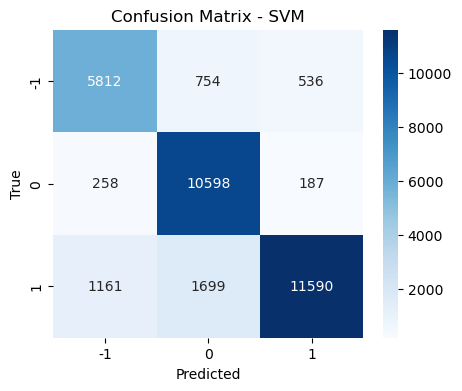

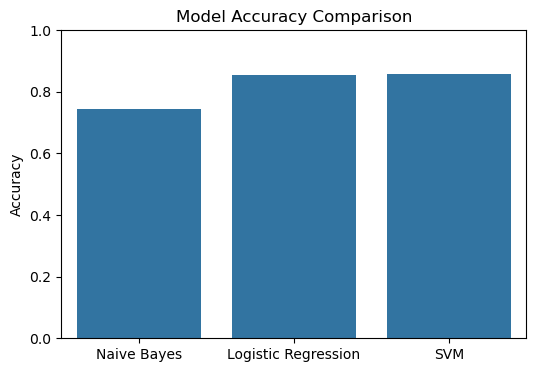

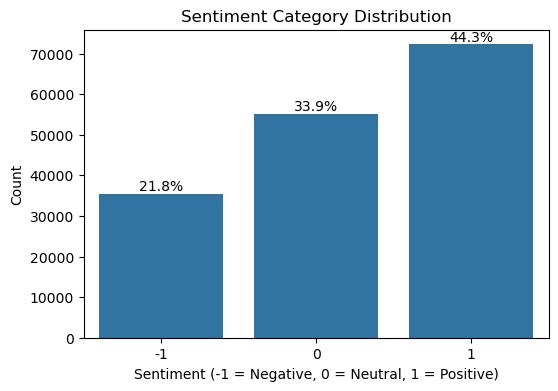

✅ Certain Predictions:
                                                tweet predicted_sentiment  \
0  I really love the new policies implemented by ...            Positive   
1  The government is failing to deliver on promises.             Neutral   
2  Not sure how I feel about the upcoming elections.            Positive   

   confidence certainty  
0    0.999694   Certain  
1    0.822567   Certain  
2    0.929539   Certain  

⚠️ Uncertain Predictions (review these):
 Empty DataFrame
Columns: [tweet, predicted_sentiment, confidence, certainty]
Index: []


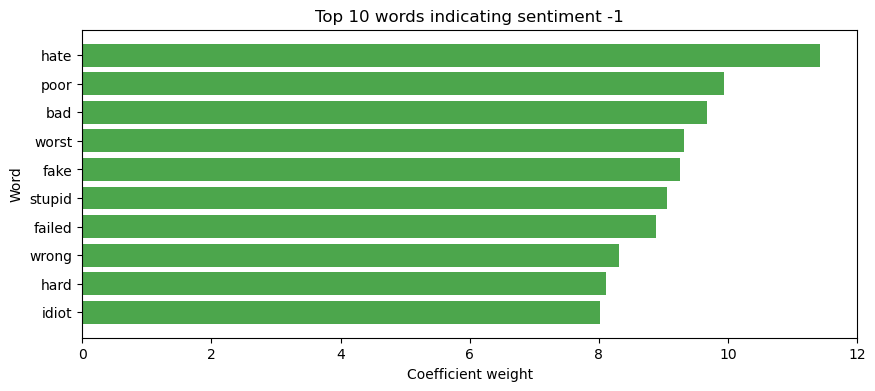

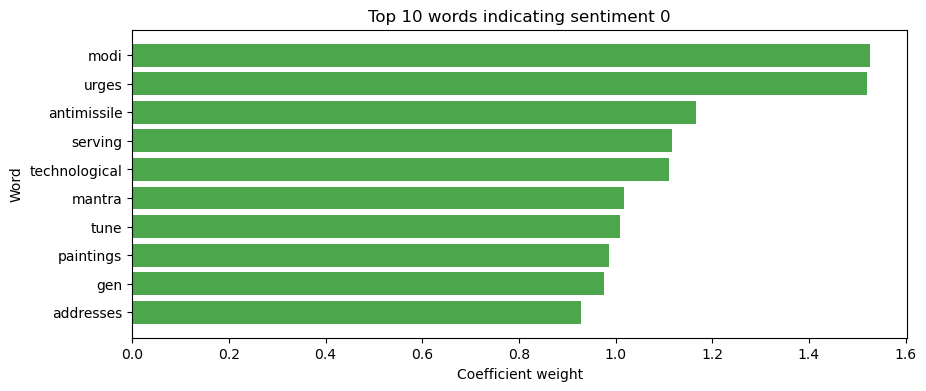

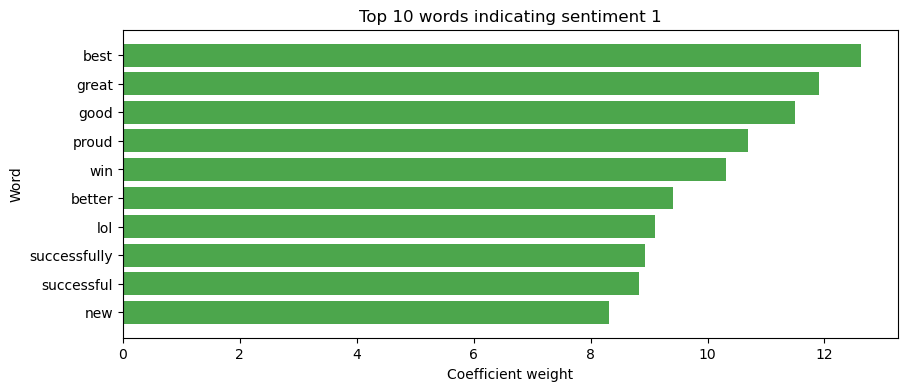

In [2]:
# 📌 Complete Sentiment Analysis Pipeline 

# 1. Import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from imblearn.over_sampling import RandomOverSampler

# 2. Load dataset
df = pd.read_csv("Twitter_Data.csv", encoding='utf-8')

# 3. Clean and handle missing values
df["clean_text"] = df["clean_text"].fillna("")
df["category"] = pd.to_numeric(df["category"], errors="coerce")
df = df.dropna(subset=["category"])
df["category"] = df["category"].astype(int)

# 4. Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["clean_text"].apply(preprocess_text)

# 5. Features and labels
X = df["clean_text"]
y = df["category"]

# 6. TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf = tfidf.fit_transform(X)

# 7. Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# 8. Oversample minority classes
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print("Before oversampling:\n", y_train.value_counts())
print("After oversampling:\n", y_train_res.value_counts())

# 9. Train models
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC()
}

results = {}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    
    print(f"\n📌 {name} Results:")
    print("Accuracy:", acc)
    print(classification_report(y_test, preds))
    
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# 10. Model accuracy comparison (future-proof)
plt.figure(figsize=(6,4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

# 11. Sentiment distribution (future-proof)
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Sentiment Category Distribution")
plt.xlabel("Sentiment (-1 = Negative, 0 = Neutral, 1 = Positive)")
plt.ylabel("Count")
total = len(y)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    plt.gca().annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()),
                       ha='center', va='bottom', fontsize=10)
plt.show()

# 12. Predict function with labels, confidence, and uncertainty
def predict_sentiment(new_texts, model, vectorizer=tfidf, threshold=0.6):
    clean_texts = [preprocess_text(t) for t in new_texts]
    X_new = vectorizer.transform(clean_texts)
    preds_numeric = model.predict(X_new)
    sentiment_map = {-1: "Negative", 0: "Neutral", 1: "Positive"}
    preds_labels = [sentiment_map[p] for p in preds_numeric]
    
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_new)
        confidence = [max(p) for p in probs]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_new)
        if len(scores.shape) == 1:
            confidence = [abs(s) for s in scores]
        else:
            confidence = [max(s) for s in scores]
    else:
        confidence = [None] * len(preds_numeric)
    
    uncertain_flag = ["Uncertain" if c is not None and c < threshold else "Certain" for c in confidence]
    
    return pd.DataFrame({
        "tweet": new_texts,
        "predicted_sentiment": preds_labels,
        "confidence": confidence,
        "certainty": uncertain_flag
    })

# 13. Example usage
new_tweets = [
    "I really love the new policies implemented by Modi!",
    "The government is failing to deliver on promises.",
    "Not sure how I feel about the upcoming elections."
]

predictions = predict_sentiment(new_tweets, models["Logistic Regression"], threshold=0.6)

# Separate certain and uncertain predictions
certain_tweets = predictions[predictions["certainty"] == "Certain"]
uncertain_tweets = predictions[predictions["certainty"] == "Uncertain"]

print("✅ Certain Predictions:\n", certain_tweets)
print("\n⚠️ Uncertain Predictions (review these):\n", uncertain_tweets)

# 14. Visualize most important words (Logistic Regression)
def plot_top_words(model, vectorizer, top_n=10):
    feature_names = vectorizer.get_feature_names_out()
    
    if not hasattr(model, "coef_"):
        print("Feature importance visualization only works with models that have coefficients (e.g., Logistic Regression).")
        return
    
    for i, class_label in enumerate(model.classes_):
        coef = model.coef_[i]
        top_indices = np.argsort(coef)[-top_n:]
        
        plt.figure(figsize=(10,4))
        plt.barh(range(top_n), coef[top_indices], color='green', alpha=0.7)
        plt.yticks(range(top_n), [feature_names[j] for j in top_indices])
        plt.title(f"Top {top_n} words indicating sentiment {class_label}")
        plt.xlabel("Coefficient weight")
        plt.ylabel("Word")
        plt.show()

# Plot top words
plot_top_words(models["Logistic Regression"], tfidf, top_n=10)
